## **Supervise Multi AI Agent Architecture**


In [1]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langgraph.graph import StateGraph, END, MessagesState
from typing import TypedDict, Annotated, List, Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from datetime import datetime
import random
import os

In [2]:
# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str

    research_data: str
    analysis: str
    final_report: str
    current_task: str
    task_complete: bool = False

In [3]:
llm = ChatOllama(model="deepseek-v3.1:671b-cloud")

In [4]:
# ===================================
# Supervisor with Ollama LLM
# ===================================


def create_supervisor_chain():
    """Creates the supervisor decision chain"""

    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])

    return supervisor_prompt | llm

In [5]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Ollama LLM"""

    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))

    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })

    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)

    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."

    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."

    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."

    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."

    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [6]:
# ===================================
# Agent 1: Researcher
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Ollama LLM to gather information"""

    task = state.get("current_task", "research topic")

    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""

    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content

    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."

    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [7]:
# ===================================
# Agent 2: Analyst
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Ollama llm to analyze the research"""

    research_data = state.get("research_data", "")
    task = state.get("current_task", "")

    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""

    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content

    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."

    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [8]:
# ===================================
# Agent 3: Writer
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Ollama llm to create final report"""

    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")

    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""

    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content

    # Create final formatted report
    final_report = f"""
        📄 FINAL REPORT
        {'='*50}
        Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
        Topic: {task}
        {'='*50}

        {report}

        {'='*50}
        Report compiled by Multi-Agent AI System powered by Ollama
        """

    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [9]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""

    next_agent = state.get("next_agent", "supervisor")

    if next_agent == "end" or state.get("task_complete", False):
        return END

    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent

    return "supervisor"

In [10]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

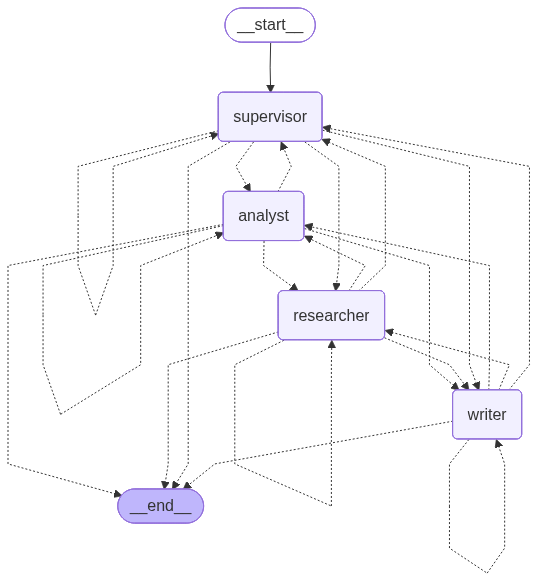

In [11]:
graph = workflow.compile()
graph

In [12]:
response = graph.invoke(HumanMessage(
    content="What are the benefits and risks of AI in healthcare?")
)

researcher
analyst
writer


In [15]:
print(response['final_report'])


        📄 FINAL REPORT
        Generated: 2026-02-12 00:08
        Topic: 📊 Analyst: I've completed the analysis.

Top insights:
Of course. As a data analyst, I have analyzed the provided research data on the state of "No Task" or "Tasklessness." Here is a breakdown of key insights, strategic implications, risks, opportunities, and actionable recommendations.

### 1. Key Insights and Patterns

The data reveals that "no task" is a multifaceted state with significant quantitative and qualitative impacts.

*   **Not Idleness, ...

        Of course. Here is a professional executive report based on the provided analysis and research findings.

***

### **Executive Report: The Strategic Management of 'Tasklessness'**

**Date:** October 26, 2023
**Prepared For:** Senior Leadership
**Subject:** Analysis of the 'No Task' State: Balancing Costs, Innovation, and Well-being

**Executive Summary**
This report analyzes the state of "tasklessness"—periods where individuals have no assigned, specifi

In [18]:
response

{'messages': [AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='ab048a32-6b56-422b-b4f7-b3801c6a3fc8', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='🔍 Researcher: I\'ve completed the research on \'No task\'.\n\nKey findings:\nOf course. As a research specialist, I will treat your query for "No task" by interpreting it as a topic worthy of examination: the concept of having **no assigned task** or **tasklessness**.\n\nHere is a comprehensive overview of this state within professional, psychological, and technological contexts.\n\n### 1. Key Facts and Background\n\nThe term "no task" describes a state where an individual or system has no specific, assigned work or objective to accomplish within a given timeframe. This concep...', additional_kwargs={}, response_metadata={}, id='700bc47f-0784-42d1-b61b-07eb962b8ff5', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='📋 Supervisor: 